# Download Data

Import libraries

In [ ]:
import torch
import torch.nn as nn
from torch import nn
import warnings
from torchvision import models
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import glob
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.checkpoint import checkpoint
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
cityscapes_id = "1OlElYRhKovWEc8gu32E8at-xNfEQniGq" # cityscapes.zip
model_weights_id = "1VOmwEwd73ktbCaSlugCPRGEwq9QY85aW" # deeplab_resnet_pretrained_imagenet.pth

In [ ]:
!pip install gdown
!gdown --id {cityscapes_id} -O "Cityscapes.zip"
!gdown --id {model_weights_id} -O "deeplab_resnet_pretrained_imagenet.pth"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1OlElYRhKovWEc8gu32E8at-xNfEQniGq
From (redirected): https://drive.google.com/uc?id=1OlElYRhKovWEc8gu32E8at-xNfEQniGq&confirm=t&uuid=8ed3dd9e-3491-4a9f-90fe-538f7f6c6c99
To: /content/Cityscapes.zip
100% 4.97G/4.97G [00:49<00:00, 101MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1VOmwEwd73ktbCaSlugCPRGEwq9QY85aW
From (redirected): https://drive.google.com/uc?id=1VOmwEwd73ktbCaSlugCPRGEwq9QY85aW&confirm=t&uuid=b11aed6d-1315-4440-a6a8-cb244568763c
To: /content/deeplab_res

In [ ]:
!unzip -q "/content/Cityscapes.zip" -d "/content"

replace /content/Cityscapes/Cityspaces/gtFine/train/hanover/hanover_000000_000164_gtFine_color.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Cityscapes Dataset

Dataset definition

In [ ]:
class CityscapesDataset(Dataset):
    def __init__(self, root_dir, split='train', image_transform=None, label_transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and labels.
            split (string): One of 'train', 'val', or 'test'. Determine the sub-folder.
            image_transform (callable, optional): Transform to be applied on images.
            label_transform (callable, optional): Transform to be applied on labels.
        """
        self.root_dir = root_dir
        self.split = split
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.images_dir = os.path.join(root_dir, 'images', split)
        self.labels_dir = os.path.join(root_dir, 'gtFine', split)

        self.image_paths = sorted(glob.glob(os.path.join(self.images_dir, '**', '*_leftImg8bit.png'), recursive=True))
        self.label_paths = sorted(glob.glob(os.path.join(self.labels_dir, '**', '*_gtFine_labelTrainIds.png'), recursive=True))

        assert len(self.image_paths) == len(self.label_paths), 'Number of images and labels should be equal'

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)

        if self.image_transform:
            image = self.image_transform(image)

        if self.label_transform:
            label = self.label_transform(label)

        return image, label

Test Dataset class is working

Number of images in dataset: 500
Image type: <class 'torch.Tensor'>, shape: torch.Size([3, 512, 1024]), dtype: torch.float32
Label type: <class 'torch.Tensor'>, shape: torch.Size([1, 512, 1024]), dtype: torch.uint8


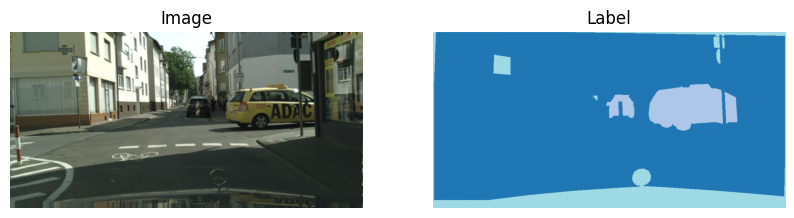

In [ ]:
if __name__ == "__main__":
    # Different transformations for images and labels
    image_transform = transforms.Compose([
        transforms.Resize((512, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
    ])

    label_transform = transforms.Compose([
        transforms.Resize((512, 1024), interpolation=Image.NEAREST),  # No antialiasing for labels
        transforms.PILToTensor()  # Keeps int values, no normalization
    ])

    # Dataset instantiation
    root_dir = 'Cityscapes/Cityspaces'  # Path to the Cityscapes dataset
    dataset = CityscapesDataset(
        root_dir=root_dir,
        split='val',
        image_transform=image_transform,
        label_transform=label_transform
    )

    # Dataset info
    print(f"Number of images in dataset: {len(dataset)}")

    # Load first example
    image, label = dataset[0]

    print(f"Image type: {type(image)}, shape: {image.shape}, dtype: {image.dtype}")
    print(f"Label type: {type(label)}, shape: {label.shape}, dtype: {label.dtype}")

    # Visualization functions
    def show_tensor_image(tensor, title=""):
        # Denormalize the image
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean

        np_img = tensor.numpy().transpose(1, 2, 0)
        # Clip values to be between 0 and 1
        np_img = np.clip(np_img, 0, 1)
        plt.imshow(np_img)
        plt.title(title)
        plt.axis('off')

    def show_tensor_label(tensor, title=""):
        if tensor.dim() == 3:
            tensor = tensor[0]
        plt.imshow(tensor.numpy(), cmap='tab20')  # tab20 colormap for class labels
        plt.title(title)
        plt.axis('off')

    # Display image and label
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    show_tensor_image(image, "Image")
    plt.subplot(1, 2, 2)
    show_tensor_label(label, "Label")
    plt.show()

# DeeplabV2

DeeplabV2 same as the professor

In [ ]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint

affine_par = True


class Bottleneck(nn.Module):
    """
    Bottleneck block used for residual connections in the ResNet architecture.

    Expansion is set to 4 to align with ResNet-101 specifications.
    Includes dilation for atrous convolutions, as used in DeepLab.
    """
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, affine=affine_par)
        for param in self.bn1.parameters():
            param.requires_grad = False

        # 3x3 convolution with optional dilation
        padding = dilation
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1,
                               padding=padding, bias=False, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(planes, affine=affine_par)
        for param in self.bn2.parameters():
            param.requires_grad = False

        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine=affine_par)
        for param in self.bn3.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """
        Forward pass for the Bottleneck block with optional residual connection.
        """
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ClassifierModule(nn.Module):
    """
    Classification module for semantic segmentation.

    This module applies a series of convolutional layers
    with varying dilation rates for spatial feature extraction.
    """
    def __init__(self, inplanes, dilation_series, padding_series, num_classes):
        super(ClassifierModule, self).__init__()
        self.conv2d_list = nn.ModuleList()

        for dilation, padding in zip(dilation_series, padding_series):
            self.conv2d_list.append(
                nn.Conv2d(
                    inplanes,
                    num_classes,
                    kernel_size=3,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=True
                )
            )

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        """
        Forward pass for the classification module.
        """
        out = self.conv2d_list[0](x)
        for i in range(1, len(self.conv2d_list)):
            out += self.conv2d_list[i](x)
        return out


class ResNetMulti(nn.Module):
    """
    ResNet-based backbone for DeepLabV2.

    Incorporates atrous convolutions and uses gradient checkpointing for memory efficiency.
    """
    def __init__(self, block, layers, num_classes, use_checkpointing=True):
        super(ResNetMulti, self).__init__()
        self.inplanes = 64

        # Enable gradient checkpointing if specified
        self.use_checkpointing = use_checkpointing

        # Initial convolution and batch normalization layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine=affine_par)
        for param in self.bn1.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        # Residual layers with optional dilations
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)

        # Final classifier module
        self.layer6 = ClassifierModule(2048, [6, 12, 18, 24], [6, 12, 18, 24], num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        self.multi_level = False

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        """
        Constructs a single residual layer with the specified parameters.
        """
        downsample = None
        if (stride != 1 or self.inplanes != planes * block.expansion or
                dilation in [2, 4]):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, affine=affine_par)
            )
            for param in downsample._modules['1'].parameters():
                param.requires_grad = False

        layers = []
        layers.append(
            block(self.inplanes, planes, stride, dilation=dilation, downsample=downsample)
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def _checkpointed_layer(self, layer, x):
        """
        Applies gradient checkpointing to the given layer.
        """
        def custom_forward(*inputs):
            return layer(*inputs)
        return checkpoint.checkpoint(custom_forward, x)

    def forward(self, x):
        """
        Forward pass for the full network with optional gradient checkpointing.
        """
        _, _, H, W = x.size()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        if self.use_checkpointing and self.training:
            x = self.layer1(x)
            x = self._checkpointed_layer(self.layer2, x)
            x = self._checkpointed_layer(self.layer3, x)
            x = self._checkpointed_layer(self.layer4, x)
        else:
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

        x = self.layer6(x)
        x = nn.functional.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)

        if self.training:
            return x, None, None
        return x

    def get_1x_lr_params_no_scale(self):
        """
        Generator that returns all parameters except those in the last layer.
        """
        modules_to_yield = [self.conv1, self.bn1, self.layer1, self.layer2, self.layer3, self.layer4]

        for module in modules_to_yield:
            for submodule in module.modules():
                for param in submodule.parameters():
                    if param.requires_grad:
                        yield param

    def get_10x_lr_params(self):
        """
        Generator that returns parameters for the final classification layer.
        """
        to_yield = []
        if self.multi_level:
            to_yield.append(self.layer5.parameters())
        to_yield.append(self.layer6.parameters())

        for param_group in to_yield:
            for param in param_group:
                yield param

    def optim_parameters(self, lr):
        """
        Returns two learning rate groups:
        - Backbone (1x LR)
        - Classifier (10x LR)
        """
        seen = set()

        def unique_params(params):
            for p in params:
                if id(p) not in seen:
                    seen.add(id(p))
                    yield p

        one_x = list(unique_params(self.get_1x_lr_params_no_scale()))
        ten_x = list(unique_params(self.get_10x_lr_params()))

        return [
            {'params': one_x, 'lr': lr},
            {'params': ten_x, 'lr': 10 * lr}
        ]


def get_deeplab_v2(num_classes=19, pretrain=True, pretrain_model_path='DeepLab_resnet_pretrained_imagenet.pth', use_checkpointing=True):
    """
    Constructs the DeepLabV2 model with ResNet backbone and optional pretraining.
    """
    model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes, use_checkpointing=use_checkpointing)

    if pretrain:
        print('Loading Deeplab pretrained weights...')
        saved_state_dict = torch.load(pretrain_model_path)
        new_params = model.state_dict().copy()
        for key in saved_state_dict:
            key_parts = key.split('.')
            new_params['.'.join(key_parts[1:])] = saved_state_dict[key]
        model.load_state_dict(new_params, strict=False)

    return model


Training DeepLabV2

In [ ]:
import argparse
import time
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import random
import os
from torch.cuda.amp import autocast, GradScaler

def get_transforms(crop_size=(512, 1024)):
    """
    Define transformations for images and labels
    """
    image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(crop_size, scale=(0.5, 2.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    label_transforms = transforms.Compose([
        transforms.RandomResizedCrop(crop_size, scale=(0.5, 2.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    val_image_transforms = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_label_transforms = transforms.Compose([
        transforms.Resize(crop_size, interpolation=Image.NEAREST),
        transforms.ToTensor()
    ])

    return image_transforms, label_transforms, val_image_transforms, val_label_transforms

def create_dataloaders(args):
    """
    Create train and validation dataloaders with dataset subset
    """
    image_transforms, label_transforms, val_image_transforms, val_label_transforms = get_transforms(
        crop_size=(args.crop_height, args.crop_width)
    )

    # Create full datasets
    train_dataset_full = CityscapesDataset(
        root_dir=args.data_dir,
        split='train',
        image_transform=image_transforms,
        label_transform=label_transforms
    )

    val_dataset_full = CityscapesDataset(
        root_dir=args.data_dir,
        split='val',
        image_transform=val_image_transforms,
        label_transform=val_label_transforms
    )

    # Create subset of the training dataset
    train_size = len(train_dataset_full)
    subset_size = int(train_size * args.dataset_fraction)

    # Set random seed for reproducibility
    random.seed(args.random_seed)

    # Create random indices for the subset
    subset_indices = random.sample(range(train_size), subset_size)

    # Create subset datasets
    train_dataset = Subset(train_dataset_full, subset_indices)

    # For validation, use a smaller subset if specified
    val_size = len(val_dataset_full)
    val_subset_size = int(val_size * args.val_dataset_fraction)
    val_subset_indices = random.sample(range(val_size), val_subset_size)
    val_dataset = Subset(val_dataset_full, val_subset_indices)

    print(f"Training on {subset_size}/{train_size} images ({args.dataset_fraction*100:.1f}% of dataset)")
    print(f"Validating on {val_subset_size}/{val_size} images ({args.val_dataset_fraction*100:.1f}% of dataset)")

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True
    )

    return train_loader, val_loader

def train_one_epoch(model, loader, optimizer, criterion, epoch, args, writer):
    """
    Train the model for one epoch with AMP
    """
    model.train()
    train_loss = 0.0
    num_batches = len(loader)
    # Initialize GradScaler for AMP
    scaler = GradScaler()

    for i, (images, labels) in enumerate(loader):
        # Handle Subset dataset wrapping
        if isinstance(images, list):
            images = images[0]
            labels = labels[0]

        # Convert labels to long and remove the extra channel dimension
        labels = labels.squeeze(1).long()

        # Move data to the device
        images = images.to(args.device)
        labels = labels.to(args.device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Use autocast for mixed precision training
        with autocast():
            # Forward pass
            outputs, _, _ = model(images)
            # Calculate loss
            loss = criterion(outputs, labels)

        # Backward pass with scaled gradients
        scaler.scale(loss).backward()
        # Step the optimizer with scaled gradients
        scaler.step(optimizer)
        # Update the scaler for the next iteration
        scaler.update()

        # Update statistics
        train_loss += loss.item()

        # Print progress
        if (i + 1) % args.print_freq == 0:
            print(f'Epoch [{epoch}/{args.epochs}], Step [{i+1}/{num_batches}], Loss: {loss.item():.4f}')

    # Calculate average training loss for this epoch
    train_loss /= num_batches

    # Log to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)

    return train_loss

def validate(model, loader, criterion, epoch, args, writer):
    """
    Validate the model with AMP
    """
    model.eval()
    val_loss = 0.0
    num_batches = len(loader)

    # Initialize metrics (mean IoU)
    intersection_sum = torch.zeros(args.num_classes).to(args.device)
    union_sum = torch.zeros(args.num_classes).to(args.device)

    with torch.no_grad():
        for images, labels in loader:
            # Handle Subset dataset wrapping
            if isinstance(images, list):
                images = images[0]
                labels = labels[0]

            # Convert labels to long and remove the extra channel dimension
            labels = labels.squeeze(1).long()

            # Move data to the device
            images = images.to(args.device)
            labels = labels.to(args.device)

            # Use autocast for mixed precision inference
            with autocast():
                # Forward pass
                outputs = model(images)
                # Calculate loss
                loss = criterion(outputs, labels)

            # Update validation loss
            val_loss += loss.item()

            # Calculate IoU
            _, predicted = torch.max(outputs, 1)

            # Calculate intersection and union for each class
            for cls in range(args.num_classes):
                pred_mask = (predicted == cls)
                target_mask = (labels == cls)
                intersection = (pred_mask & target_mask).sum().item()
                union = (pred_mask | target_mask).sum().item()
                intersection_sum[cls] += intersection
                union_sum[cls] += union

    # Calculate average validation loss
    val_loss /= num_batches

    # Calculate IoU for each class and mean IoU
    iou = torch.zeros(args.num_classes)
    for cls in range(args.num_classes):
        if union_sum[cls] > 0:
            iou[cls] = intersection_sum[cls] / union_sum[cls]

    mean_iou = torch.mean(iou).item()

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('mIoU/val', mean_iou, epoch)

    print(f'Validation - Epoch: {epoch}, Loss: {val_loss:.4f}, Mean IoU: {mean_iou:.4f}')

    return val_loss, mean_iou

def train(args):
    """
    Main training function with AMP support
    """
    # Set up TensorBoard
    writer = SummaryWriter(log_dir=args.log_dir)

    # Create model
    model = get_deeplab_v2(
        num_classes=args.num_classes,
        pretrain=args.pretrain,
        pretrain_model_path=args.pretrain_model_path,
        use_checkpointing=args.use_checkpointing
    )
    model = model.to(args.device)

    # Define criterion
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # Get model parameters with different learning rates
    optimizer_params = model.optim_parameters(args.lr)

    # Define optimizer
    optimizer = optim.SGD(
        optimizer_params,
        momentum=args.momentum,
        weight_decay=args.weight_decay
    )

    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.PolynomialLR(
        optimizer,
        total_iters=args.epochs,
        power=0.9
    )

    # Create dataloaders with subset
    train_loader, val_loader = create_dataloaders(args)

    # Load checkpoint if resuming
    if args.resume:
        if os.path.isfile(args.resume):
            print(f"Loading checkpoint '{args.resume}'")
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            scheduler.load_state_dict(checkpoint['scheduler'])
            print(f"Loaded checkpoint '{args.resume}' (epoch {checkpoint['epoch']})")
        else:
            print(f"No checkpoint found at '{args.resume}'")

    # Best mIoU tracker for model saving
    best_miou = 0.0

    # Training loop
    for epoch in range(args.start_epoch, args.epochs):
        # Train for one epoch
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch, args, writer)

        # Validate
        val_loss, miou = validate(model, val_loader, criterion, epoch, args, writer)

        # Update learning rate
        scheduler.step()

        # Save checkpoint
        is_best = miou > best_miou
        best_miou = max(miou, best_miou)

        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_miou': best_miou
        }

        checkpoint_path = os.path.join(args.save_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save(checkpoint, checkpoint_path)

        if is_best:
            best_path = os.path.join(args.save_dir, 'model_best.pth')
            torch.save(checkpoint, best_path)
            print(f"Saved new best model with mIoU: {best_miou:.4f}")

    writer.close()
    print(f"Training completed. Best mIoU: {best_miou:.4f}")

class Config:
    def __init__(self):
        # Dataset parameters
        self.data_dir = './cityscapes'
        self.crop_height = 512
        self.crop_width = 1024
        self.num_classes = 19

        # Dataset subset parameters
        self.dataset_fraction = 0.2  # Use 20% of the training data
        self.val_dataset_fraction = 0.3  # Use 30% of the validation data
        self.random_seed = 42  # For reproducible dataset splits

        # Training parameters
        self.epochs = 2
        self.batch_size = 8
        self.lr = 0.001
        self.momentum = 0.9
        self.weight_decay = 0.0005
        self.num_workers = 4

        # Model parameters
        self.pretrain = True
        self.pretrain_model_path = 'deeplab_resnet_pretrained_imagenet.pth'
        self.use_checkpointing = False

        # Saving and loading parameters
        self.save_dir = './checkpoints'
        self.log_dir = './logs'
        self.resume = ''
        self.start_epoch = 0
        self.print_freq = 10

        # Create directories
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)

        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Now you can run the training like this:
args = Config()
# Customize any parameters
args.data_dir = 'Cityscapes/Cityspaces'
args.batch_size = 6  # Adjust based on your GPU
args.dataset_fraction = 1  # Use only 20% of the training data
args.val_dataset_fraction = 1  # Use only 30% of the validation data

# Run training
train(args)


Loading Deeplab pretrained weights...
Training on 157/1572 images (10.0% of dataset)
Validating on 100/500 images (20.0% of dataset)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-11-8a7f0438fcd6>:119: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-11-8a7f0438fcd6>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/

Epoch [0/2], Step [10/78], Loss: 0.6940


KeyboardInterrupt: 

with gradient checkpointing and batch=4

12 min of training

without gradient checkpointing and batch=3

10 min of training

without gradient checkpointing and batch=2

13 min of training

try without gradient checkpointing and batch=2
then try the same things but in this case without data augmentation in the training class

Test DeepLabV2

In [ ]:
!pip install fvcore

Using device: cuda
Loading model...
Loading Deeplab pretrained weights...
Loaded trained weights from checkpoints/model_best.pth

Calculating FLOPs and parameters...
| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 43.901M                | 0.375T     |
|  conv1                         |  9.408K                |  1.233G    |
|   conv1.weight                 |   (64, 3, 7, 7)        |            |
|  bn1                           |  0.128K                |  16.777M   |
|   bn1.weight                   |   (64,)                |            |
|   bn1.bias                     |   (64,)                |            |
|  layer1                        |  0.216M                |  7.155G    |
|   layer1.0                     |   75.008K              |   2.487G   |
|    layer1.0.conv1              |    4.096K              |    0.136G  |
|    layer1.0.bn1              

Calculating Latency & FPS: 100%|██████████| 100/100 [00:24<00:00,  4.03it/s]


Mean Latency: 247.14 ± 3.93 ms
Mean FPS: 4.05 ± 0.06

Creating validation dataloader...

Visualizing predictions for sample images...


  0%|          | 0/5 [00:00<?, ?it/s]

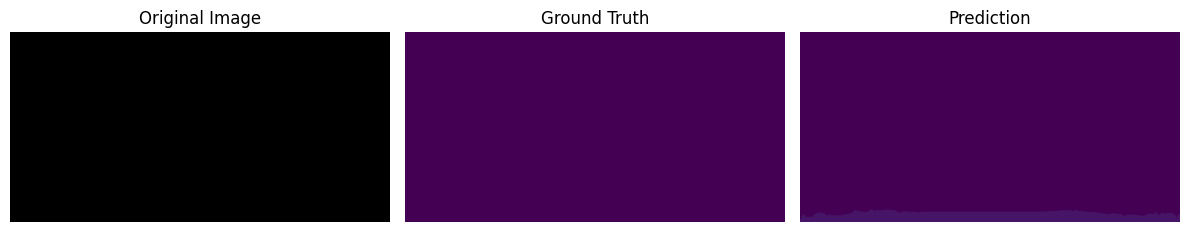

 20%|██        | 1/5 [00:00<00:03,  1.03it/s]

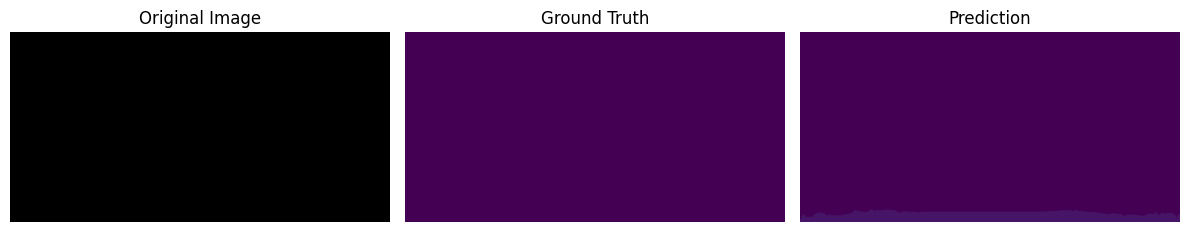

 40%|████      | 2/5 [00:01<00:02,  1.38it/s]

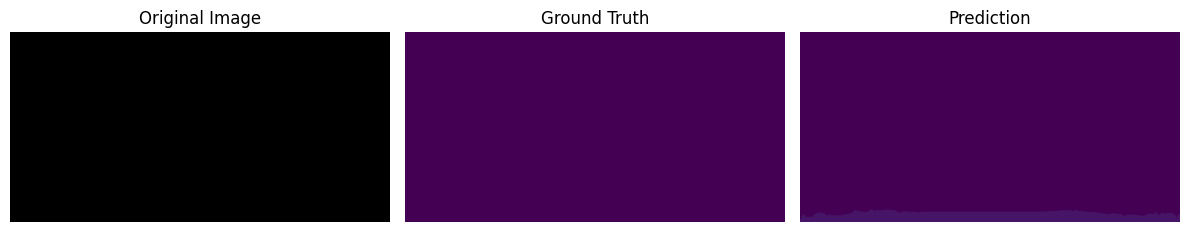

 60%|██████    | 3/5 [00:02<00:01,  1.53it/s]

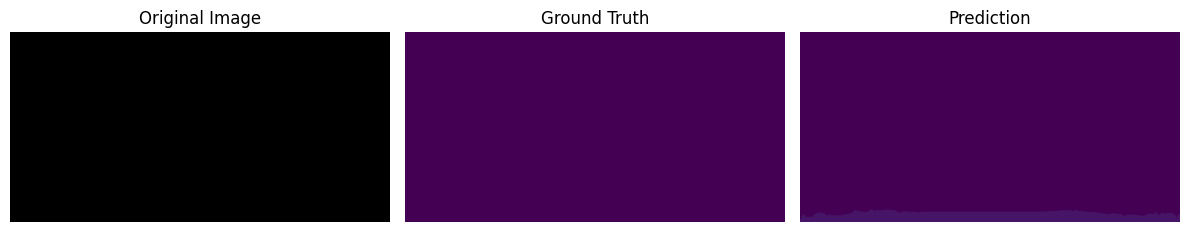

 80%|████████  | 4/5 [00:02<00:00,  1.63it/s]

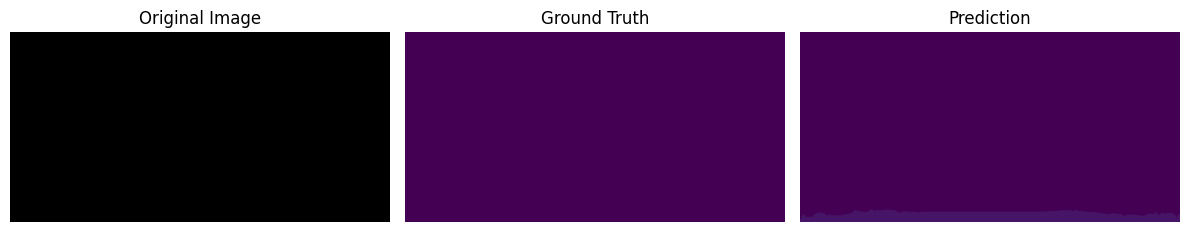

100%|██████████| 5/5 [00:03<00:00,  1.50it/s]



Calculating mIoU...


Calculating mIoU: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


**Per-Class IoU Results:**
Class 0: IoU = 0.9502 (95.02%)
Class 1: IoU = 0.0000 (0.00%)
Class 2: IoU = 0.0000 (0.00%)
Class 3: IoU = 0.0000 (0.00%)
Class 4: IoU = 0.0000 (0.00%)
Class 5: IoU = 0.0000 (0.00%)
Class 6: IoU = 0.0000 (0.00%)
Class 7: IoU = 0.0000 (0.00%)
Class 8: IoU = 0.0000 (0.00%)
Class 9: IoU = 0.0000 (0.00%)
Class 10: IoU = 0.0000 (0.00%)
Class 11: IoU = 0.0000 (0.00%)
Class 12: IoU = 0.0000 (0.00%)
Class 13: IoU = 0.0000 (0.00%)
Class 14: IoU = 0.0000 (0.00%)
Class 15: IoU = 0.0000 (0.00%)
Class 16: IoU = 0.0000 (0.00%)
Class 17: IoU = 0.0000 (0.00%)
Class 18: IoU = 0.0000 (0.00%)

**Overall Metrics:**
Mean IoU: 0.0500 (5.00%)
Mean Pixel Accuracy: 0.0500 (5.00%)

=== Model Evaluation Summary ===
mIoU (%): 5.00 (DeepLab v2 Paper: ~67.6% on Cityscapes val)
Mean Pixel Accuracy (%): 5.00
Latency (ms): 247.14 ± 3.93
FPS: 4.05 ± 0.06
GFLOPs: 374.66
Parameters (M): 43.80


In [ ]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from fvcore.nn import FlopCountAnalysis, flop_count_table
from tqdm import tqdm

def get_val_transforms(crop_size=(512, 1024)):
    """Define transformations for validation images and labels"""
    val_image_transforms = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_label_transforms = transforms.Compose([
        transforms.Resize(crop_size, interpolation=Image.NEAREST),
        transforms.ToTensor()
    ])

    return val_image_transforms, val_label_transforms

def create_val_dataloader(data_dir, batch_size=1, num_workers=4, crop_size=(512, 1024)):
    """Create validation dataloader"""
    val_image_transforms, val_label_transforms = get_val_transforms(crop_size)

    val_dataset = CityscapesDataset(
        root_dir=data_dir,
        split='val',
        image_transform=val_image_transforms,
        label_transform=val_label_transforms
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return val_loader

def calculate_miou(model, dataloader, num_classes=19, device='cuda'):
    """Calculate mean IoU on the validation set"""
    model.eval()

    # Initialize metrics
    intersection_sum = torch.zeros(num_classes).to(device)
    union_sum = torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calculating mIoU"):
            # Convert labels to long and remove the extra channel dimension
            labels = labels.squeeze(1).long()

            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass - handle different return types
            try:
                if hasattr(model, 'module'):
                    outputs = model.module(images)
                else:
                    outputs = model(images)

                # Handle different model output formats
                if isinstance(outputs, tuple) and len(outputs) == 3:
                    outputs = outputs[0]  # Take the first element if model returns a tuple of 3
                elif isinstance(outputs, tuple) and len(outputs) > 0:
                    outputs = outputs[0]  # Take the first element for any tuple
                # else, outputs is already what we need
            except Exception as e:
                print(f"Error during model inference: {e}")
                continue

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Calculate intersection and union for each class
            for cls in range(num_classes):
                pred_mask = (predicted == cls)
                target_mask = (labels == cls)
                intersection = (pred_mask & target_mask).sum().item()
                union = (pred_mask | target_mask).sum().item()
                intersection_sum[cls] += intersection
                union_sum[cls] += union

    # Calculate IoU for each class
    iou = torch.zeros(num_classes)
    for cls in range(num_classes):
        if union_sum[cls] > 0:
            iou[cls] = intersection_sum[cls] / union_sum[cls]

    # Calculate mean IoU
    mean_iou = torch.mean(iou).item()

    # Print class-wise IoU
    for cls in range(num_classes):
        print(f"Class {cls} IoU: {iou[cls]:.4f}")

    return mean_iou

def calculate_latency_fps(model, height=512, width=1024, iterations=1000, device='cuda'):
    """Calculate model latency and FPS"""
    model.eval()

    # Create a random input tensor
    image = torch.rand(1, 3, height, width).to(device)

    # Warm-up runs
    for _ in range(10):
        with torch.no_grad():
            _ = model(image)

    # Measure latency
    latencies = []
    fps_values = []

    for _ in tqdm(range(iterations), desc="Calculating Latency & FPS"):
        torch.cuda.synchronize()
        start = time.time()

        with torch.no_grad():
            _ = model(image)

        torch.cuda.synchronize()
        end = time.time()

        latency = end - start
        fps = 1.0 / latency

        latencies.append(latency)
        fps_values.append(fps)

    # Convert to numpy arrays for calculations
    latencies = np.array(latencies)
    fps_values = np.array(fps_values)

    # Calculate statistics
    mean_latency = np.mean(latencies) * 1000  # Convert to ms
    std_latency = np.std(latencies) * 1000    # Convert to ms
    mean_fps = np.mean(fps_values)
    std_fps = np.std(fps_values)

    return mean_latency, std_latency, mean_fps, std_fps

def calculate_flops_params(model, height=512, width=1024, device='cuda'):
    """Calculate FLOPs and number of parameters"""
    # Create a dummy input for FLOPs calculation
    image = torch.zeros((1, 3, height, width)).to(device)

    # Calculate FLOPs
    flops = FlopCountAnalysis(model, image)
    flops_table = flop_count_table(flops)
    total_flops = flops.total() / 1e9  # Convert to GFLOPs

    # Calculate number of parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6  # Convert to M

    return total_flops, total_params, flops_table

def load_model(model_path, num_classes=19, device='cuda'):
    """Load the DeepLab V2 model from checkpoint"""
    # Initialize model
    model = get_deeplab_v2(
        num_classes=num_classes,
        pretrain=False,  # No need to load ImageNet weights for evaluation
        use_checkpointing=False  # No need for checkpointing during evaluation
    )

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    if 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model = model.to(device)
    return model

def main():
    # Configuration
    config = {
        'model_path': 'checkpoints/model_best.pth',  # Path to your trained model
        'data_dir': 'Cityscapes/Cityspaces',
        'num_classes': 19,
        'batch_size': 1,  # For evaluation, we usually use batch_size=1
        'num_workers': 4,
        'crop_height': 512,
        'crop_width': 1024,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }

    print(f"Using device: {config['device']}")

    # Load model
    print("Loading model...")
    model = load_model(
        model_path=config['model_path'],
        num_classes=config['num_classes'],
        device=config['device']
    )
    model.eval()

    # Calculate FLOPs and parameters
    print("\nCalculating FLOPs and parameters...")
    total_flops, total_params, flops_table = calculate_flops_params(
        model=model,
        height=config['crop_height'],
        width=config['crop_width'],
        device=config['device']
    )
    print(flops_table)
    print(f"Total GFLOPs: {total_flops:.2f}")
    print(f"Total Parameters (M): {total_params:.2f}")

    # Calculate latency and FPS
    print("\nCalculating latency and FPS...")
    mean_latency, std_latency, mean_fps, std_fps = calculate_latency_fps(
        model=model,
        height=config['crop_height'],
        width=config['crop_width'],
        iterations=1000,  # You might want to reduce this for faster evaluation
        device=config['device']
    )
    print(f"Mean Latency: {mean_latency:.2f} ± {std_latency:.2f} ms")
    print(f"Mean FPS: {mean_fps:.2f} ± {std_fps:.2f}")

    # Create dataloader for validation
    print("\nCreating validation dataloader...")
    val_loader = create_val_dataloader(
        data_dir=config['data_dir'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        crop_size=(config['crop_height'], config['crop_width'])
    )

    # Calculate mIoU
    print("\nCalculating mIoU...")
    mean_iou = calculate_miou(
        model=model,
        dataloader=val_loader,
        num_classes=config['num_classes'],
        device=config['device']
    )
    print(f"Mean IoU: {mean_iou:.4f} ({mean_iou*100:.2f}%)")

    # Print summary table
    print("\n=== Model Evaluation Summary ===")
    print("=" * 40)
    print(f"mIoU (%): {mean_iou*100:.2f}")
    print(f"Latency (ms): {mean_latency:.2f} ± {std_latency:.2f}")
    print(f"FPS: {mean_fps:.2f} ± {std_fps:.2f}")
    print(f"GFLOPs: {total_flops:.2f}")
    print(f"Parameters (M): {total_params:.2f}")
    print("=" * 40)

if __name__ == "__main__":
    main()

Testing on images

DeepLabV2 improved

Add ASPP Module: DeepLabv2 employs the Atrous Spatial Pyramid Pooling (ASPP) module, which allows for multi-scale context aggregation. You should incorporate this module into the code.

DenseCRF for Post Processing: Utilize DenseCRF for the refinement of segmentation boundaries, which improves spatial consistency.

Utilize Deeper Backbone Network: Use a more powerful backbone such as ResNet-101, which is referenced in the DeepLabv2 paper.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

affine_par = True

class ASPPModule(nn.Module):
    """
    Modulo ASPP (Atrous Spatial Pyramid Pooling).

    Consente di estrarre contesto a più scale grazie a convoluzioni con dilation diversa,
    in linea con quanto evidenziato da alcune varianti DeepLab <sup data-citation="2" className="inline select-none [&>a]:rounded-2xl [&>a]:border [&>a]:px-1.5 [&>a]:py-0.5 [&>a]:transition-colors shadow [&>a]:bg-ds-bg-subtle [&>a]:text-xs [&>svg]:w-4 [&>svg]:h-4 relative -top-[2px] citation-shimmer"><a href="https://www.researchgate.net/publication/303812083_DeepLab_Semantic_Image_Segmentation_with_Deep_Convolutional_Nets_Atrous_Convolution_and_Fully_Connected_CRFs" target="_blank" title="DeepLab: Semantic Image Segmentation with Deep ...">2</a></sup>.
    """
    def __init__(self, in_channels, out_channels, dilations=(6, 12, 18)):
        super(ASPPModule, self).__init__()
        self.convs = nn.ModuleList()

        # 1x1 convolution per preservare informazioni di dettaglio
        self.convs.append(
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        )

        # Convoluzioni atrous di varie dilations
        for dilation in dilations:
            self.convs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=1, padding=dilation, dilation=dilation, bias=False),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True)
                )
            )

        # Pooling globale + conv 1x1
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Convoluzione finale per mescolare i canali
        self.conv_out = nn.Sequential(
            nn.Conv2d(out_channels * (len(self.convs) + 1), out_channels,
                      kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Lista di feature estratte a varie scale
        features = []
        for conv in self.convs:
            features.append(conv(x))

        # Pooling globale per contesto a larga scala
        gpool = self.global_pool(x)
        gpool = F.interpolate(gpool, size=x.size()[2:], mode='bilinear', align_corners=True)
        features.append(gpool)

        # Concatenazione e fusione
        out = torch.cat(features, dim=1)
        out = self.conv_out(out)
        return out

class EnhancedClassifierModule(nn.Module):
    """
    Esempio di "classificatore" che integra il modulo ASPP al posto del precedente ClassifierModule.
    """
    def __init__(self, inplanes, num_classes, aspp_out_channels=256):
        super(EnhancedClassifierModule, self).__init__()
        self.aspp = ASPPModule(inplanes, aspp_out_channels)
        self.conv_out = nn.Conv2d(aspp_out_channels, num_classes, kernel_size=1)

    def forward(self, x):
        x = self.aspp(x)
        x = self.conv_out(x)
        return x

class ResNetMulti(nn.Module):
    """
    Backbone ResNet modificato per DeepLab, con supporto al nuovo modulo ASPP.
    """
    def __init__(self, block, layers, num_classes, use_checkpointing=True):
        super(ResNetMulti, self).__init__()
        self.inplanes = 64
        self.use_checkpointing = use_checkpointing

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine=affine_par)
        for param in self.bn1.parameters():
            param.requires_grad = False

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        # Layers residui
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)

        # Sostituiamo la vecchia ClassifierModule con il nuovo modulo ASPP
        self.layer6 = EnhancedClassifierModule(2048, num_classes)

        # Inizializzazione pesi
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        self.multi_level = False

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if (stride != 1 or self.inplanes != planes * block.expansion or
            dilation in [2, 4]):
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, affine=affine_par)
            )
            for param in downsample._modules['1'].parameters():
                param.requires_grad = True

        layers = []
        layers.append(block(self.inplanes, planes, stride, dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))

        return nn.Sequential(*layers)

    def _checkpointed_layer(self, layer, x):
        def custom_forward(*inputs):
            return layer(*inputs)
        return checkpoint.checkpoint(custom_forward, x)

    def forward(self, x):
        _, _, H, W = x.size()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Uso di gradient checkpointing opzionale
        if self.use_checkpointing and self.training:
            x = self.layer1(x)
            x = self._checkpointed_layer(self.layer2, x)
            x = self._checkpointed_layer(self.layer3, x)
            x = self._checkpointed_layer(self.layer4, x)
        else:
            x = self.layer1(x)
            x = self.layer2(x)
            x = self.layer3(x)
            x = self.layer4(x)

        x = self.layer6(x)
        x = nn.functional.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)

        if self.training:
            return x, None, None
        return x

    def get_1x_lr_params_no_scale(self):
        """
        Generator that returns all parameters except those in the last layer.
        """
        modules_to_yield = [self.conv1, self.bn1, self.layer1, self.layer2, self.layer3, self.layer4]

        for module in modules_to_yield:
            for submodule in module.modules():
                for param in submodule.parameters():
                    if param.requires_grad:
                        yield param

    def get_10x_lr_params(self):
        """
        Generator that returns parameters for the final classification layer.
        """
        to_yield = []
        if self.multi_level:
            to_yield.append(self.layer5.parameters())
        to_yield.append(self.layer6.parameters())

        for param_group in to_yield:
            for param in param_group:
                yield param

    def optim_parameters(self, lr):
        """
        Returns two learning rate groups:
        - Backbone (1x LR)
        - Classifier (10x LR)
        """
        seen = set()

        def unique_params(params):
            for p in params:
                if id(p) not in seen:
                    seen.add(id(p))
                    yield p

        one_x = list(unique_params(self.get_1x_lr_params_no_scale()))
        ten_x = list(unique_params(self.get_10x_lr_params()))

        return [
            {'params': one_x, 'lr': lr},
            {'params': ten_x, 'lr': 10 * lr}
        ]


def get_deeplab_v2_improved(num_classes=19, pretrain=True, pretrain_model_path='DeepLab_resnet_pretrained_imagenet.pth', use_checkpointing=True):
    """
    Constructs the DeepLabV2 model with ResNet backbone and optional pretraining.
    """
    model = ResNetMulti(Bottleneck, [3, 4, 23, 3], num_classes, use_checkpointing=use_checkpointing)

    if pretrain:
        print('Loading Deeplab pretrained weights...')
        saved_state_dict = torch.load(pretrain_model_path)
        new_params = model.state_dict().copy()
        for key in saved_state_dict:
            key_parts = key.split('.')
            new_params['.'.join(key_parts[1:])] = saved_state_dict[key]
        model.load_state_dict(new_params, strict=False)

    return model


Training deeplabv2 improved

In [ ]:
import glob
import argparse
import time
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
import random

def get_transforms(crop_size=(512, 1024)):
    """
    Define transformations for images and labels
    """
    image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(crop_size, scale=(0.5, 2.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    label_transforms = transforms.Compose([
        transforms.RandomResizedCrop(crop_size, scale=(0.5, 2.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

    val_image_transforms = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_label_transforms = transforms.Compose([
        transforms.Resize(crop_size, interpolation=Image.NEAREST),
        transforms.ToTensor()
    ])

    return image_transforms, label_transforms, val_image_transforms, val_label_transforms

def create_dataloaders(args):
    """
    Create train and validation dataloaders with dataset subset
    """
    image_transforms, label_transforms, val_image_transforms, val_label_transforms = get_transforms(
        crop_size=(args.crop_height, args.crop_width)
    )

    # Create full datasets
    train_dataset_full = CityscapesDataset(
        root_dir=args.data_dir,
        split='train',
        image_transform=image_transforms,
        label_transform=label_transforms
    )

    val_dataset_full = CityscapesDataset(
        root_dir=args.data_dir,
        split='val',
        image_transform=val_image_transforms,
        label_transform=val_label_transforms
    )

    # Create subset of the training dataset
    train_size = len(train_dataset_full)
    subset_size = int(train_size * args.dataset_fraction)

    # Set random seed for reproducibility
    random.seed(args.random_seed)

    # Create random indices for the subset
    subset_indices = random.sample(range(train_size), subset_size)

    # Create subset datasets
    train_dataset = Subset(train_dataset_full, subset_indices)

    # For validation, use a smaller subset if specified
    val_size = len(val_dataset_full)
    val_subset_size = int(val_size * args.val_dataset_fraction)
    val_subset_indices = random.sample(range(val_size), val_subset_size)
    val_dataset = Subset(val_dataset_full, val_subset_indices)

    print(f"Training on {subset_size}/{train_size} images ({args.dataset_fraction*100:.1f}% of dataset)")
    print(f"Validating on {val_subset_size}/{val_size} images ({args.val_dataset_fraction*100:.1f}% of dataset)")

    train_loader = DataLoader(
        train_dataset,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=args.num_workers,
        pin_memory=True,
        drop_last=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True
    )

    return train_loader, val_loader

def train_one_epoch(model, loader, optimizer, criterion, epoch, args, writer):
    """
    Train the model for one epoch
    """
    model.train()
    train_loss = 0.0
    num_batches = len(loader)

    for i, (images, labels) in enumerate(loader):
        # Handle Subset dataset wrapping
        if isinstance(images, list):
            images = images[0]
            labels = labels[0]

        # Convert labels to long and remove the extra channel dimension
        labels = labels.squeeze(1).long()

        # Move data to the device
        images = images.to(args.device)
        labels = labels.to(args.device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs, _, _ = model(images)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update statistics
        train_loss += loss.item()

        # Print progress
        if (i + 1) % args.print_freq == 0:
            print(f'Epoch [{epoch}/{args.epochs}], Step [{i+1}/{num_batches}], Loss: {loss.item():.4f}')

    # Calculate average training loss for this epoch
    train_loss /= num_batches

    # Log to TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)

    return train_loss

def validate(model, loader, criterion, epoch, args, writer):
    """
    Validate the model
    """
    model.eval()
    val_loss = 0.0
    num_batches = len(loader)

    # Initialize metrics (mean IoU)
    intersection_sum = torch.zeros(args.num_classes).to(args.device)
    union_sum = torch.zeros(args.num_classes).to(args.device)

    with torch.no_grad():
        for images, labels in loader:
            # Handle Subset dataset wrapping
            if isinstance(images, list):
                images = images[0]
                labels = labels[0]

            # Convert labels to long and remove the extra channel dimension
            labels = labels.squeeze(1).long()

            # Move data to the device
            images = images.to(args.device)
            labels = labels.to(args.device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Update validation loss
            val_loss += loss.item()

            # Calculate IoU
            _, predicted = torch.max(outputs, 1)

            # Calculate intersection and union for each class
            for cls in range(args.num_classes):
                pred_mask = (predicted == cls)
                target_mask = (labels == cls)
                intersection = (pred_mask & target_mask).sum().item()
                union = (pred_mask | target_mask).sum().item()
                intersection_sum[cls] += intersection
                union_sum[cls] += union

    # Calculate average validation loss
    val_loss /= num_batches

    # Calculate IoU for each class and mean IoU
    iou = torch.zeros(args.num_classes)
    for cls in range(args.num_classes):
        if union_sum[cls] > 0:
            iou[cls] = intersection_sum[cls] / union_sum[cls]

    mean_iou = torch.mean(iou).item()

    # Log metrics to TensorBoard
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('mIoU/val', mean_iou, epoch)

    print(f'Validation - Epoch: {epoch}, Loss: {val_loss:.4f}, Mean IoU: {mean_iou:.4f}')

    return val_loss, mean_iou

def train(args):
    """
    Main training function
    """
    # Set up TensorBoard
    writer = SummaryWriter(log_dir=args.log_dir)

    # Create model
    model = get_deeplab_v2_improved(
        num_classes=args.num_classes,
        pretrain=args.pretrain,
        pretrain_model_path=args.pretrain_model_path,
        use_checkpointing=args.use_checkpointing
    )
    model = model.to(args.device)

    # Define criterion
    criterion = nn.CrossEntropyLoss(ignore_index=255)

    # Get model parameters with different learning rates
    optimizer_params = model.optim_parameters(args.lr)

    # Define optimizer
    optimizer = optim.SGD(
        optimizer_params,
        momentum=args.momentum,
        weight_decay=args.weight_decay
    )

    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.PolynomialLR(
        optimizer,
        total_iters=args.epochs,
        power=0.9
    )

    # Create dataloaders with subset
    train_loader, val_loader = create_dataloaders(args)

    # Load checkpoint if resuming
    if args.resume:
        if os.path.isfile(args.resume):
            print(f"Loading checkpoint '{args.resume}'")
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            scheduler.load_state_dict(checkpoint['scheduler'])
            print(f"Loaded checkpoint '{args.resume}' (epoch {checkpoint['epoch']})")
        else:
            print(f"No checkpoint found at '{args.resume}'")

    # Best mIoU tracker for model saving
    best_miou = 0.0

    # Training loop
    for epoch in range(args.start_epoch, args.epochs):
        # Train for one epoch
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch, args, writer)

        # Validate
        val_loss, miou = validate(model, val_loader, criterion, epoch, args, writer)

        # Update learning rate
        scheduler.step()

        # Save checkpoint
        is_best = miou > best_miou
        best_miou = max(miou, best_miou)

        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_miou': best_miou
        }

        import os
        checkpoint_path = os.path.join(args.save_dir, f'checkpoint_epoch_{epoch+1}.pth')
        torch.save(checkpoint, checkpoint_path)

        if is_best:
            best_path = os.path.join(args.save_dir, 'model_best.pth')
            torch.save(checkpoint, best_path)
            print(f"Saved new best model with mIoU: {best_miou:.4f}")

    writer.close()
    print(f"Training completed. Best mIoU: {best_miou:.4f}")

class Config:
    def __init__(self):
        # Dataset parameters
        self.data_dir = './cityscapes'
        self.crop_height = 512
        self.crop_width = 1024
        self.num_classes = 19

        # Dataset subset parameters
        self.dataset_fraction = 0.2  # Use 20% of the training data
        self.val_dataset_fraction = 0.3  # Use 30% of the validation data
        self.random_seed = 42  # For reproducible dataset splits

        # Training parameters
        self.epochs = 2
        self.batch_size = 8
        self.lr = 2.5e-4
        self.momentum = 0.9
        self.weight_decay = 5e-4
        self.num_workers = 4

        # Model parameters
        self.pretrain = True
        self.pretrain_model_path = 'deeplab_resnet_pretrained_imagenet.pth'
        self.use_checkpointing = True

        # Saving and loading parameters
        self.save_dir = './checkpoints'
        self.log_dir = './logs'
        self.resume = ''
        self.start_epoch = 0
        self.print_freq = 10

        # Create directories
        import os
        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)

        # Set device
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Now you can run the training like this:
args = Config()
# Customize any parameters
args.data_dir = 'Cityscapes/Cityspaces'
args.batch_size = 4  # Adjust based on your GPU
args.dataset_fraction = 0.2  # Use only 20% of the training data
args.val_dataset_fraction = 0.3  # Use only 30% of the validation data

# Run training
train(args)


NameError: name 'Bottleneck' is not defined

Test DeepLabV2 improved

In [ ]:
import os
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from fvcore.nn import FlopCountAnalysis, flop_count_table
from tqdm import tqdm

def get_val_transforms(crop_size=(512, 1024)):
    """Define transformations for validation images and labels"""
    val_image_transforms = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_label_transforms = transforms.Compose([
        transforms.Resize(crop_size, interpolation=Image.NEAREST),
        transforms.ToTensor()
    ])

    return val_image_transforms, val_label_transforms

def create_val_dataloader(data_dir, batch_size=1, num_workers=4, crop_size=(512, 1024)):
    """Create validation dataloader"""
    val_image_transforms, val_label_transforms = get_val_transforms(crop_size)

    val_dataset = CityscapesDataset(
        root_dir=data_dir,
        split='val',
        image_transform=val_image_transforms,
        label_transform=val_label_transforms
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return val_loader

def calculate_miou(model, dataloader, num_classes=19, device='cuda'):
    """Calculate mean IoU on the validation set"""
    model.eval()

    # Initialize metrics
    intersection_sum = torch.zeros(num_classes).to(device)
    union_sum = torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calculating mIoU"):
            # Convert labels to long and remove the extra channel dimension
            labels = labels.squeeze(1).long()

            # Move data to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass - handle different return types
            try:
                if hasattr(model, 'module'):
                    outputs = model.module(images)
                else:
                    outputs = model(images)

                # Handle different model output formats
                if isinstance(outputs, tuple) and len(outputs) == 3:
                    outputs = outputs[0]  # Take the first element if model returns a tuple of 3
                elif isinstance(outputs, tuple) and len(outputs) > 0:
                    outputs = outputs[0]  # Take the first element for any tuple
                # else, outputs is already what we need
            except Exception as e:
                print(f"Error during model inference: {e}")
                continue

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            # Calculate intersection and union for each class
            for cls in range(num_classes):
                pred_mask = (predicted == cls)
                target_mask = (labels == cls)
                intersection = (pred_mask & target_mask).sum().item()
                union = (pred_mask | target_mask).sum().item()
                intersection_sum[cls] += intersection
                union_sum[cls] += union

    # Calculate IoU for each class
    iou = torch.zeros(num_classes)
    for cls in range(num_classes):
        if union_sum[cls] > 0:
            iou[cls] = intersection_sum[cls] / union_sum[cls]

    # Calculate mean IoU
    mean_iou = torch.mean(iou).item()

    # Print class-wise IoU
    for cls in range(num_classes):
        print(f"Class {cls} IoU: {iou[cls]:.4f}")

    return mean_iou

def calculate_latency_fps(model, height=512, width=1024, iterations=1000, device='cuda'):
    """Calculate model latency and FPS"""
    model.eval()

    # Create a random input tensor
    image = torch.rand(1, 3, height, width).to(device)

    # Warm-up runs
    for _ in range(10):
        with torch.no_grad():
            _ = model(image)

    # Measure latency
    latencies = []
    fps_values = []

    for _ in tqdm(range(iterations), desc="Calculating Latency & FPS"):
        torch.cuda.synchronize()
        start = time.time()

        with torch.no_grad():
            _ = model(image)

        torch.cuda.synchronize()
        end = time.time()

        latency = end - start
        fps = 1.0 / latency

        latencies.append(latency)
        fps_values.append(fps)

    # Convert to numpy arrays for calculations
    latencies = np.array(latencies)
    fps_values = np.array(fps_values)

    # Calculate statistics
    mean_latency = np.mean(latencies) * 1000  # Convert to ms
    std_latency = np.std(latencies) * 1000    # Convert to ms
    mean_fps = np.mean(fps_values)
    std_fps = np.std(fps_values)

    return mean_latency, std_latency, mean_fps, std_fps

def calculate_flops_params(model, height=512, width=1024, device='cuda'):
    """Calculate FLOPs and number of parameters"""
    # Create a dummy input for FLOPs calculation
    image = torch.zeros((1, 3, height, width)).to(device)

    # Calculate FLOPs
    flops = FlopCountAnalysis(model, image)
    flops_table = flop_count_table(flops)
    total_flops = flops.total() / 1e9  # Convert to GFLOPs

    # Calculate number of parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6  # Convert to M

    return total_flops, total_params, flops_table

def load_model(model_path, num_classes=19, device='cuda'):
    """Load the DeepLab V2 model from checkpoint"""
    # Initialize model
    model = get_deeplab_v2(
        num_classes=num_classes,
        pretrain=False,  # No need to load ImageNet weights for evaluation
        use_checkpointing=False  # No need for checkpointing during evaluation
    )

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    if 'state_dict' in checkpoint:
        model.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint)

    model = model.to(device)
    return model

def main():
    # Configuration
    config = {
        'model_path': 'checkpoints/model_best.pth',  # Path to your trained model
        'data_dir': 'Cityscapes/Cityspaces',
        'num_classes': 19,
        'batch_size': 1,  # For evaluation, we usually use batch_size=1
        'num_workers': 4,
        'crop_height': 512,
        'crop_width': 1024,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }

    print(f"Using device: {config['device']}")

    # Load model
    print("Loading model...")
    model = load_model(
        model_path=config['model_path'],
        num_classes=config['num_classes'],
        device=config['device']
    )
    model.eval()

    # Calculate FLOPs and parameters
    print("\nCalculating FLOPs and parameters...")
    total_flops, total_params, flops_table = calculate_flops_params(
        model=model,
        height=config['crop_height'],
        width=config['crop_width'],
        device=config['device']
    )
    print(flops_table)
    print(f"Total GFLOPs: {total_flops:.2f}")
    print(f"Total Parameters (M): {total_params:.2f}")

    # Calculate latency and FPS
    print("\nCalculating latency and FPS...")
    mean_latency, std_latency, mean_fps, std_fps = calculate_latency_fps(
        model=model,
        height=config['crop_height'],
        width=config['crop_width'],
        iterations=1000,  # You might want to reduce this for faster evaluation
        device=config['device']
    )
    print(f"Mean Latency: {mean_latency:.2f} ± {std_latency:.2f} ms")
    print(f"Mean FPS: {mean_fps:.2f} ± {std_fps:.2f}")

    # Create dataloader for validation
    print("\nCreating validation dataloader...")
    val_loader = create_val_dataloader(
        data_dir=config['data_dir'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        crop_size=(config['crop_height'], config['crop_width'])
    )

    # Calculate mIoU
    print("\nCalculating mIoU...")
    mean_iou = calculate_miou(
        model=model,
        dataloader=val_loader,
        num_classes=config['num_classes'],
        device=config['device']
    )
    print(f"Mean IoU: {mean_iou:.4f} ({mean_iou*100:.2f}%)")

    # Print summary table
    print("\n=== Model Evaluation Summary ===")
    print("=" * 40)
    print(f"mIoU (%): {mean_iou*100:.2f}")
    print(f"Latency (ms): {mean_latency:.2f} ± {std_latency:.2f}")
    print(f"FPS: {mean_fps:.2f} ± {std_fps:.2f}")
    print(f"GFLOPs: {total_flops:.2f}")
    print(f"Parameters (M): {total_params:.2f}")
    print("=" * 40)

if __name__ == "__main__":
    main()

# BiSeNet

BiSeNet same as the professor

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
warnings.filterwarnings(action='ignore')


class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, input):
        x = self.conv1(input)
        return self.relu(self.bn(x))


class Spatial_path(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.convblock1 = ConvBlock(in_channels=3, out_channels=64)
        self.convblock2 = ConvBlock(in_channels=64, out_channels=128)
        self.convblock3 = ConvBlock(in_channels=128, out_channels=256)

    def forward(self, input):
        x = self.convblock1(input)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x


class AttentionRefinementModule(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.sigmoid = nn.Sigmoid()
        self.in_channels = in_channels
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input):
        # global average pooling
        x = self.avgpool(input)
        assert self.in_channels == x.size(1), 'in_channels and out_channels should all be {}'.format(x.size(1))
        x = self.conv(x)
        x = self.sigmoid(self.bn(x))
        # x = self.sigmoid(x)
        # channels of input and x should be same
        x = torch.mul(input, x)
        return x


class FeatureFusionModule(torch.nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        # self.in_channels = input_1.channels + input_2.channels
        # resnet101 3328 = 256(from spatial path) + 1024(from context path) + 2048(from context path)
        # resnet18  1024 = 256(from spatial path) + 256(from context path) + 512(from context path)
        self.in_channels = in_channels

        self.convblock = ConvBlock(in_channels=self.in_channels, out_channels=num_classes, stride=1)
        self.conv1 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

    def forward(self, input_1, input_2):
        x = torch.cat((input_1, input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.convblock(x)
        x = self.avgpool(feature)

        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))
        x = torch.mul(feature, x)
        x = torch.add(x, feature)
        return x


class BiSeNet(torch.nn.Module):
    def __init__(self, num_classes, context_path):
        super().__init__()
        # build spatial path
        self.saptial_path = Spatial_path()

        # build context path
        self.context_path = build_contextpath(name=context_path)

        # build attention refinement module  for resnet 101
        if context_path == 'resnet101':
            self.attention_refinement_module1 = AttentionRefinementModule(1024, 1024)
            self.attention_refinement_module2 = AttentionRefinementModule(2048, 2048)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=1024, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=2048, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 3328)

        elif context_path == 'resnet18':
            # build attention refinement module  for resnet 18
            self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
            self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
            # supervision block
            self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
            self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)
            # build feature fusion module
            self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)
        else:
            print('Error: unspport context_path network \n')

        # build final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

        self.init_weight()

        self.mul_lr = []
        self.mul_lr.append(self.saptial_path)
        self.mul_lr.append(self.attention_refinement_module1)
        self.mul_lr.append(self.attention_refinement_module2)
        self.mul_lr.append(self.supervision1)
        self.mul_lr.append(self.supervision2)
        self.mul_lr.append(self.feature_fusion_module)
        self.mul_lr.append(self.conv)

    def init_weight(self):
        for name, m in self.named_modules():
            if 'context_path' not in name:
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                elif isinstance(m, nn.BatchNorm2d):
                    m.eps = 1e-5
                    m.momentum = 0.1
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, input):
        # output of spatial path
        sx = self.saptial_path(input)

        # output of context path
        cx1, cx2, tail = self.context_path(input)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)
        # upsampling
        cx1 = torch.nn.functional.interpolate(cx1, size=sx.size()[-2:], mode='bilinear')
        cx2 = torch.nn.functional.interpolate(cx2, size=sx.size()[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        if self.training == True:
            cx1_sup = self.supervision1(cx1)
            cx2_sup = self.supervision2(cx2)
            cx1_sup = torch.nn.functional.interpolate(cx1_sup, size=input.size()[-2:], mode='bilinear')
            cx2_sup = torch.nn.functional.interpolate(cx2_sup, size=input.size()[-2:], mode='bilinear')

        # output of feature fusion module
        result = self.feature_fusion_module(sx, cx)

        # upsampling
        result = torch.nn.functional.interpolate(result, scale_factor=8, mode='bilinear')
        result = self.conv(result)

        if self.training == True:
            return result, cx1_sup, cx2_sup

        return result

In [ ]:
class resnet18(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet18(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


class resnet101(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features = models.resnet101(pretrained=pretrained)
        self.conv1 = self.features.conv1
        self.bn1 = self.features.bn1
        self.relu = self.features.relu
        self.maxpool1 = self.features.maxpool
        self.layer1 = self.features.layer1
        self.layer2 = self.features.layer2
        self.layer3 = self.features.layer3
        self.layer4 = self.features.layer4

    def forward(self, input):
        x = self.conv1(input)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)  # 1 / 4
        feature2 = self.layer2(feature1)  # 1 / 8
        feature3 = self.layer3(feature2)  # 1 / 16
        feature4 = self.layer4(feature3)  # 1 / 32
        # global average pooling to build tail
        tail = torch.mean(feature4, 3, keepdim=True)
        tail = torch.mean(tail, 2, keepdim=True)
        return feature3, feature4, tail


def build_contextpath(name):
    model = {
        'resnet18': resnet18(pretrained=True),
        'resnet101': resnet101(pretrained=True)
    }
    return model[name]

Training BiSeNet

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


def bisenet_get_transforms(crop_size=(512, 1024)):
    """
    Define image and label transformations for training and validation.
    """
    image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(crop_size, scale=(0.5, 2.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    label_transforms = transforms.Compose([
        transforms.RandomResizedCrop(crop_size, scale=(0.5, 2.0), interpolation=Image.NEAREST),
        transforms.PILToTensor()
    ])

    val_image_transforms = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_label_transforms = transforms.Compose([
        transforms.Resize(crop_size, interpolation=Image.NEAREST),
        transforms.PILToTensor()
    ])

    return image_transforms, label_transforms, val_image_transforms, val_label_transforms


def create_dataloaders(args):
    """
    Create train and validation dataloaders with dataset subset.
    """
    image_transforms, label_transforms, val_image_transforms, val_label_transforms = bisenet_get_transforms(
        crop_size=(args.crop_height, args.crop_width)
    )


    train_dataset_full = CityscapesDataset(
        root_dir=args.data_dir, split='train',
        image_transform=image_transforms, label_transform=label_transforms
    )

    val_dataset_full = CityscapesDataset(
        root_dir=args.data_dir, split='val',
        image_transform=val_image_transforms, label_transform=val_label_transforms
    )

    # Sample subsets for training and validation
    train_size = len(train_dataset_full)
    subset_size = int(train_size * args.dataset_fraction)
    random.seed(args.random_seed)
    subset_indices = random.sample(range(train_size), subset_size)
    train_dataset = Subset(train_dataset_full, subset_indices)

    val_size = len(val_dataset_full)
    val_subset_size = int(val_size * args.val_dataset_fraction)
    val_subset_indices = random.sample(range(val_size), val_subset_size)
    val_dataset = Subset(val_dataset_full, val_subset_indices)

    print(f"Training on {subset_size}/{train_size} images ({args.dataset_fraction*100:.1f}% of dataset)")
    print(f"Validating on {val_subset_size}/{val_size} images ({args.val_dataset_fraction*100:.1f}% of dataset)")

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                              num_workers=args.num_workers, pin_memory=True, drop_last=True)

    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                            num_workers=args.num_workers, pin_memory=True)

    return train_loader, val_loader

# Training function
def bisenet_train(model, loader, optimizer, criterion, epoch, args, writer):

    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(loader):
        labels = labels.squeeze(1).long()

        images = images.to(args.device)
        labels = labels.to(args.device)

        optimizer.zero_grad()
        outputs, aux1, aux2 = model(images)

        loss_main = criterion(outputs, labels)
        loss_aux1 = criterion(aux1, labels)
        loss_aux2 = criterion(aux2, labels)
        loss = loss_main + 0.4 * loss_aux1 + 0.4 * loss_aux2

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i + 1) % args.print_freq == 0:
            print(f'Epoch [{epoch}/{args.epochs}], Step [{i+1}/{len(loader)}], Loss: {loss.item():.4f}')

    writer.add_scalar('Loss/train', train_loss / len(loader), epoch)

# Validation function
def validate(model, loader, criterion, epoch, args, writer):
    """
    Validate the model and compute mIoU.
    """
    model.eval()
    val_loss = 0.0
    intersection_sum = torch.zeros(args.num_classes).to(args.device)
    union_sum = torch.zeros(args.num_classes).to(args.device)

    with torch.no_grad():
        for images, labels in loader:
            labels = labels.squeeze(1).long()
            images, labels = images.to(args.device), labels.to(args.device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            for cls in range(args.num_classes):
                pred_mask = (predicted == cls)
                target_mask = (labels == cls)
                intersection = (pred_mask & target_mask).sum().item()
                union = (pred_mask | target_mask).sum().item()
                intersection_sum[cls] += intersection
                union_sum[cls] += union

    mean_iou = torch.mean(torch.where(union_sum > 0, intersection_sum / union_sum, torch.zeros_like(intersection_sum))).item()

    writer.add_scalar('Loss/val', val_loss / len(loader), epoch)
    writer.add_scalar('mIoU/val', mean_iou, epoch)

    print(f'Validation - Epoch {epoch}, Loss: {val_loss:.4f}, Mean IoU: {mean_iou:.4f}')

# Configuration class
class Config:
    def __init__(self):
        # Dataset parameters
        self.data_dir = 'Cityscapes/Cityspaces'
        self.crop_height = 1024
        self.crop_width = 512
        self.num_classes = 19

        # Dataset subset parameters
        self.dataset_fraction = 0.2
        self.val_dataset_fraction = 0.3
        self.random_seed = 42

        # Training parameters
        self.epochs = 50
        self.batch_size = 8
        self.lr = 2.5e-4
        self.momentum = 0.9
        self.weight_decay = 0.01
        self.num_workers = 4

        # Model parameters
        self.pretrain = True
        self.context_path = 'resnet18'
        self.use_checkpointing = False

        # Saving and logging
        self.save_dir = './checkpoints_bisenet'
        self.log_dir = './logs_bisenet'
        self.resume = ''
        self.start_epoch = 0
        self.print_freq = 10

        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate configuration
args = Config()
model = BiSeNet(num_classes=args.num_classes, context_path=args.context_path).to(args.device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
writer = SummaryWriter(log_dir=args.log_dir)

train_loader, val_loader = create_dataloaders(args)

# Training loop
for epoch in range(args.start_epoch, args.epochs):
    bisenet_train(model, train_loader, optimizer, criterion, epoch, args, writer)
    validate(model, val_loader, criterion, epoch, args, writer)

writer.close()


Training on 314/1572 images (20.0% of dataset)
Validating on 150/500 images (30.0% of dataset)


Test BiSeNet

In [ ]:
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from fvcore.nn import FlopCountAnalysis, flop_count_table
from tqdm import tqdm


def get_val_transforms(crop_size=(512, 1024)):
    """Define transformations for validation images and labels"""
    val_image_transforms = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_label_transforms = transforms.Compose([
        transforms.Resize(crop_size, interpolation=Image.NEAREST),
        transforms.ToTensor()
    ])

    return val_image_transforms, val_label_transforms

def create_val_dataloader(data_dir, batch_size=1, num_workers=4, crop_size=(512, 1024)):
    """Create validation dataloader"""
    val_image_transforms, val_label_transforms = get_val_transforms(crop_size)

    val_dataset = CityscapesDataset(
        root_dir=data_dir,
        split='val',
        image_transform=val_image_transforms,
        label_transform=val_label_transforms
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return val_loader

# ==================== Mean IoU Calculation ====================
def calculate_miou(model, dataloader, num_classes=19, device='cuda'):
    """Calculate mean IoU on the validation set"""
    model.eval()

    intersection_sum = torch.zeros(num_classes).to(device)
    union_sum = torch.zeros(num_classes).to(device)

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Calculating mIoU"):
            labels = labels.squeeze(1).long()
            images, labels = images.to(device), labels.to(device)

            try:
                outputs, aux1, aux2 = model(images)
            except Exception as e:
                print(f"Error during model inference: {e}")
                continue

            _, predicted = torch.max(outputs, 1)

            for cls in range(num_classes):
                pred_mask = (predicted == cls)
                target_mask = (labels == cls)
                intersection = (pred_mask & target_mask).sum().item()
                union = (pred_mask | target_mask).sum().item()
                intersection_sum[cls] += intersection
                union_sum[cls] += union

    iou = torch.where(union_sum > 0, intersection_sum / union_sum, torch.zeros_like(intersection_sum))
    mean_iou = torch.mean(iou).item()

    for cls in range(num_classes):
        print(f"Class {cls} IoU: {iou[cls]:.4f}")

    return mean_iou

# ==================== Latency & FPS Calculation ====================
def calculate_latency_fps(model, height=512, width=1024, iterations=1000, device='cuda'):
    """Calculate model latency and FPS"""
    model.eval()
    image = torch.rand(1, 3, height, width).to(device)

    for _ in range(10):  # Warm-up runs
        with torch.no_grad():
            _ = model(image)

    latencies = []
    fps_values = []

    for _ in tqdm(range(iterations), desc="Calculating Latency & FPS"):
        torch.cuda.synchronize()
        start = time.time()

        with torch.no_grad():
            _ = model(image)

        torch.cuda.synchronize()
        end = time.time()

        latency = end - start
        fps = 1.0 / latency

        latencies.append(latency)
        fps_values.append(fps)

    mean_latency = np.mean(latencies) * 1000  # Convert to ms
    mean_fps = np.mean(fps_values)

    return mean_latency, np.std(latencies) * 1000, mean_fps, np.std(fps_values)

# ==================== FLOPs & Parameters Calculation ====================
def calculate_flops_params(model, height=512, width=1024, device='cuda'):
    """Calculate FLOPs and number of parameters"""
    image = torch.zeros((1, 3, height, width)).to(device)

    flops = FlopCountAnalysis(model, image)
    flops_table = flop_count_table(flops)
    total_flops = flops.total() / 1e9  # Convert to GFLOPs
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6  # Convert to M

    return total_flops, total_params, flops_table

# ==================== Load BiSeNet Model ====================
def load_bisenet_model(model_path, num_classes=19, device='cuda'):
    """Load the BiSeNet model from checkpoint"""
    model = BiSeNet(num_classes=num_classes, context_path='resnet18')
    checkpoint = torch.load(model_path, map_location=device)

    if 'state_dict' in checkpoint:
        model.load_state_dict(torch.load("checkpoints_bisenet/model_best.pth", map_location="cuda"), strict=False)

    else:
        model.load_state_dict(checkpoint)

    return model.to(device)

# ==================== Evaluation ====================
def main():
    config = {
        'model_path': 'checkpoints_bisenet/model_best.pth',
        'data_dir': 'Cityscapes',
        'num_classes': 19,
        'batch_size': 1,
        'num_workers': 4,
        'crop_height': 512,
        'crop_width': 1024,
        'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    }

    print(f"Using device: {config['device']}")

    # Load BiSeNet model
    print("\nLoading BiSeNet model...")
    model = load_bisenet_model(
        model_path=config['model_path'],
        num_classes=config['num_classes'],
        device=config['device']
    )
    model.eval()

    # Calculate FLOPs & Parameters
    print("\nCalculating FLOPs & Parameters...")
    total_flops, total_params, flops_table = calculate_flops_params(
        model=model,
        height=config['crop_height'],
        width=config['crop_width'],
        device=config['device']
    )
    print(flops_table)
    print(f"Total GFLOPs: {total_flops:.2f}")
    print(f"Total Parameters (M): {total_params:.2f}")

    # Calculate Latency & FPS
    print("\nCalculating Latency & FPS...")
    mean_latency, std_latency, mean_fps, std_fps = calculate_latency_fps(
        model=model,
        height=config['crop_height'],
        width=config['crop_width'],
        iterations=1000,
        device=config['device']
    )
    print(f"Mean Latency: {mean_latency:.2f} ± {std_latency:.2f} ms")
    print(f"Mean FPS: {mean_fps:.2f} ± {std_fps:.2f}")

    # Create validation dataloader
    print("\nCreating validation dataloader...")
    val_loader = create_val_dataloader(
        data_dir=config['data_dir'],
        batch_size=config['batch_size'],
        num_workers=config['num_workers'],
        crop_size=(config['crop_height'], config['crop_width'])
    )

    # Calculate mIoU
    print("\nCalculating mIoU...")
    mean_iou = calculate_miou(
        model=model,
        dataloader=val_loader,
        num_classes=config['num_classes'],
        device=config['device']
    )
    print(f"Mean IoU: {mean_iou:.4f} ({mean_iou*100:.2f}%)")

if __name__ == "__main__":
    main()

Using device: cpu

Loading BiSeNet model...


NameError: name 'BiSeNet' is not defined

Improved BiSeNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ASPPModule(nn.Module):
    """Atrous Spatial Pyramid Pooling (ASPP) for multi-scale feature extraction."""
    def __init__(self, in_channels, out_channels, dilations=(6, 12, 18)):
        super(ASPPModule, self).__init__()
        self.convs = nn.ModuleList()


        self.convs.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))

        # Dilated convolutions at different scales
        for dilation in dilations:
            self.convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1,
                          padding=dilation, dilation=dilation, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))

        # Global Average Pooling for capturing large context
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Final 1x1 conv for output processing
        self.conv_out = nn.Sequential(
            nn.Conv2d(out_channels * (len(self.convs) + 1), out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        features = [conv(x) for conv in self.convs]
        gpool = self.global_pool(x)
        gpool = F.interpolate(gpool, size=x.shape[2:], mode='bilinear', align_corners=True)
        features.append(gpool)

        out = torch.cat(features, dim=1)
        out = self.conv_out(out)
        return out

# ==================== BiSeNet with ASPP ====================
class BiSeNetASPP(nn.Module):
    """Modified BiSeNet integrating ASPP for multi-scale segmentation."""
    def __init__(self, num_classes, backbone="resnet18"):
        super(BiSeNetASPP, self).__init__()

        # Standard backbone (ResNet-based)
        self.context_path = build_contextpath(backbone)
        self.spatial_path = Spatial_path()

        # Attention Refinement Modules (ARM)
        self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
        self.attention_refinement_module2 = AttentionRefinementModule(512, 512)

        # Feature Fusion Module with ASPP
        self.feature_fusion_module = FeatureFusionModule(num_classes, 1024)

        # ASPP integration before final classifier
        self.aspp = ASPPModule(1024, 256)
        self.final_classifier = nn.Conv2d(256, num_classes, kernel_size=1)

    def forward(self, x):
        spatial_out = self.spatial_path(x)

        cx1, cx2, tail = self.context_path(x)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, tail)

        cx1 = F.interpolate(cx1, size=spatial_out.shape[-2:], mode='bilinear')
        cx2 = F.interpolate(cx2, size=spatial_out.shape[-2:], mode='bilinear')
        cx = torch.cat((cx1, cx2), dim=1)

        fused_features = self.feature_fusion_module(spatial_out, cx)

        # ASPP processing before final classification
        aspp_out = self.aspp(fused_features)
        final_out = self.final_classifier(aspp_out)

        final_out = F.interpolate(final_out, scale_factor=8, mode='bilinear')

        return final_out


Training BiSeNet improved

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import warnings
warnings.filterwarnings("ignore")


def bisenet_get_transforms(crop_size=(512, 1024)):

    image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(crop_size, scale=(0.5, 2.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    label_transforms = transforms.Compose([
        transforms.RandomResizedCrop(crop_size, scale=(0.5, 2.0), interpolation=Image.NEAREST),
        transforms.PILToTensor()
    ])

    val_image_transforms = transforms.Compose([
        transforms.Resize(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_label_transforms = transforms.Compose([
        transforms.Resize(crop_size, interpolation=Image.NEAREST),
        transforms.PILToTensor()
    ])

    return image_transforms, label_transforms, val_image_transforms, val_label_transforms


def create_dataloaders(args):

    image_transforms, label_transforms, val_image_transforms, val_label_transforms = bisenet_get_transforms(
        crop_size=(args.crop_height, args.crop_width)
    )


    train_dataset_full = CityscapesDataset(
        root_dir=args.data_dir, split='train',
        image_transform=image_transforms, label_transform=label_transforms
    )

    val_dataset_full = CityscapesDataset(
        root_dir=args.data_dir, split='val',
        image_transform=val_image_transforms, label_transform=val_label_transforms
    )

    # Sample subsets for training and validation
    train_size = len(train_dataset_full)
    subset_size = int(train_size * args.dataset_fraction)
    random.seed(args.random_seed)
    subset_indices = random.sample(range(train_size), subset_size)
    train_dataset = Subset(train_dataset_full, subset_indices)

    val_size = len(val_dataset_full)
    val_subset_size = int(val_size * args.val_dataset_fraction)
    val_subset_indices = random.sample(range(val_size), val_subset_size)
    val_dataset = Subset(val_dataset_full, val_subset_indices)

    print(f"Training on {subset_size}/{train_size} images ({args.dataset_fraction*100:.1f}% of dataset)")
    print(f"Validating on {val_subset_size}/{val_size} images ({args.val_dataset_fraction*100:.1f}% of dataset)")

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                              num_workers=args.num_workers, pin_memory=True, drop_last=True)

    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                            num_workers=args.num_workers, pin_memory=True)

    return train_loader, val_loader

# Training function
def bisenet_train(model, loader, optimizer, criterion, epoch, args, writer):
    model.train()
    train_loss = 0.0

    for i, (images, labels) in enumerate(loader):
        labels = labels.squeeze(1).long()

        images = images.to(args.device)
        labels = labels.to(args.device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if (i + 1) % args.print_freq == 0:
            print(f'Epoch [{epoch}/{args.epochs}], Step [{i+1}/{len(loader)}], Loss: {loss.item():.4f}')

    writer.add_scalar('Loss/train', train_loss / len(loader), epoch)

# Validation function
def validate(model, loader, criterion, epoch, args, writer):
    """
    Validate the model and compute mIoU.
    """
    model.eval()
    val_loss = 0.0
    intersection_sum = torch.zeros(args.num_classes).to(args.device)
    union_sum = torch.zeros(args.num_classes).to(args.device)

    with torch.no_grad():
        for images, labels in loader:
            labels = labels.squeeze(1).long()
            images, labels = images.to(args.device), labels.to(args.device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()


            _, predicted = torch.max(outputs, dim=1)


            for cls in range(args.num_classes):
                pred_mask = (predicted == cls)
                target_mask = (labels == cls)
                intersection = (pred_mask & target_mask).sum().item()
                union = (pred_mask | target_mask).sum().item()
                intersection_sum[cls] += intersection
                union_sum[cls] += union


    mean_iou = torch.mean(
        torch.where(union_sum > 0, intersection_sum / union_sum, torch.zeros_like(intersection_sum))
    ).item()

    writer.add_scalar('Loss/val', val_loss / len(loader), epoch)
    writer.add_scalar('mIoU/val', mean_iou, epoch)

    print(f'Validation - Epoch {epoch}, Loss: {val_loss:.4f}, Mean IoU: {mean_iou:.4f}')



class Config:
    def __init__(self):

        self.data_dir = 'Cityscapes/Cityspaces'
        self.crop_height = 1024
        self.crop_width = 512
        self.num_classes = 19


        self.dataset_fraction = 0.2
        self.val_dataset_fraction = 0.3
        self.random_seed = 42


        self.epochs = 50
        self.batch_size = 8
        self.lr = 2.5e-4
        self.momentum = 0.9
        self.weight_decay = 0.01
        self.num_workers = 4


        self.pretrain = True
        self.context_path = 'resnet18'
        self.use_checkpointing = False


        self.save_dir = './checkpoints_bisenet'
        self.log_dir = './logs_bisenet'
        self.resume = ''
        self.start_epoch = 0
        self.print_freq = 10

        os.makedirs(self.save_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate configuration
args = Config()
model = BiSeNetASPP(num_classes=args.num_classes, backbone=args.context_path).to(args.device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
writer = SummaryWriter(log_dir=args.log_dir)

train_loader, val_loader = create_dataloaders(args)

# Training loop
for epoch in range(args.start_epoch, args.epochs):
    bisenet_train(model, train_loader, optimizer, criterion, epoch, args, writer)
    validate(model, val_loader, criterion, epoch, args, writer)

writer.close()

Test BiSeNet improved